In [1]:
import os
import time
import shutil
import re
import string
import pickle as pkl
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

import math
from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
class Timer():
    def __init__(self, message):
        self.message = message
        self.st_time = time.time()
    
    def end(self):
        self.elapsed = time.time()-self.st_time
        print(f'{self.message} process took {self.elapsed//60}min {round(self.elapsed//60, 2)}sec')

In [3]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [4]:
def get_text_label(raw_ds):
    list_text, list_label = [], []
    for data, _label in raw_ds:
        text = custom_standardization(data)
        revised_text = [t.numpy().decode('utf-8').replace('  ', ' ').strip() for t in text]
        label = _label.numpy().tolist()
        list_text.extend(revised_text)
        list_label.extend(label)
    return list_text, list_label

In [5]:
def sentence_tokenize(tokenizer,texts):
    result = []
    for text in texts:
        sentence = []
        word_tokens = tokenizer(text)
        result.append(word_tokens)
    return result

In [6]:
def remove_stopwords(texts, stopwords):
    result = []
    for text in texts:
        sentence = []
        for word in text:
            if word not in stopwords:
                sentence.append(word)
        result.append(sentence)
    return result

In [7]:
# Get IMDB Dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file('aclImdb_v1', url, untar=True, cache_dir='', cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb') # '/tmp/.keras/aclImdb'

84125825/84125825 [==============================] - 5s 0us/step


In [8]:
# Check files in folder
print(os.listdir(dataset_dir))
train_dir = os.path.join(dataset_dir, 'train')
print(f'Train Directory: {os.listdir(train_dir)}')
test_dir = os.path.join(dataset_dir, 'test')
print(f'Test Directory: {os.listdir(test_dir)}')

['imdb.vocab', 'README', 'test', 'train', 'imdbEr.txt']
Train Directory: ['neg', 'unsupBow.feat', 'unsup', 'labeledBow.feat', 'urls_unsup.txt', 'urls_neg.txt', 'urls_pos.txt', 'pos']
Test Directory: ['neg', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'pos']


In [9]:
# Remove Necessary
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [10]:
# Extract Dataset from Data files
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    '/tmp/.keras/aclImdb/train',
    batch_size = batch_size,
    shuffle=False
)
# raw_valid_ds = tf.keras.utils.text_dataset_from_directory(
# '/tmp/.keras/aclImdb/train',
# batch_size = batch_size,
# validation_split = 0.2,
# subset='validation',
# seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    '/tmp/.keras/aclImdb/test',
    shuffle=False,
    batch_size = batch_size)

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [11]:
# Check Dataset 
print(next(iter(raw_train_ds))[0][0]) # data
print()
print(next(iter(raw_train_ds))[1][0]) # label

tf.Tensor(b"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.", shape=(), dtype=string)

tf.Tensor(0, shape=(), dtype=int32)


In [12]:
# Train Data split into Train & Valid
raw_text, raw_label = get_text_label(raw_train_ds)
train_text, val_text, train_label, val_label = train_test_split(raw_text, raw_label, test_size=0.2, random_state=42)
test_text, test_label = get_text_label(raw_test_ds)

In [13]:
word_tokenizer = word_tokenize
timer = Timer("Tokenize")
train_raw_token = sentence_tokenize(word_tokenizer, train_text)
val_raw_token = sentence_tokenize(word_tokenizer, val_text)
test_raw_token = sentence_tokenize(word_tokenizer, test_text)
timer.end()

Tokenize process took 0.0min 0.0sec


mean: 1261.72355
(700, 2474) (600, 1899) (800, 1882) (900, 1417) (1000, 1242) (1100, 976) (1200, 818) (500, 751) (1300, 723) (400, 704)


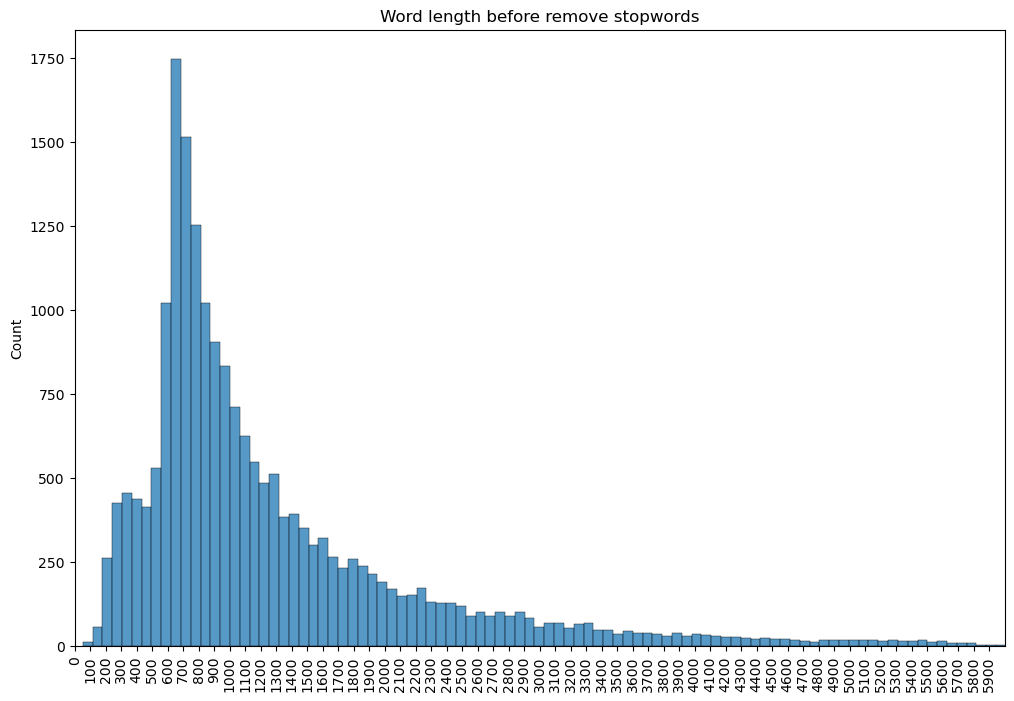

In [14]:
length_count = np.array([len(train_t) for train_t in train_text])
upper_length_count = np.array([round(len(train_t), -2) for train_t in train_text])
plt.figure(figsize = (12, 8))
sns.histplot(length_count)
plt.xlim(0, 6000)
plt.xticks(np.arange(0, 6000, 100), rotation=90)
plt.title("Word length before remove stopwords")
print(f'mean: {length_count.mean()}')

# 700~800 사이가 제일 많다.
print(*sorted(Counter(upper_length_count).items(), key=lambda x: -x[1])[:10])

In [15]:
stopwords_list = stopwords.words('english')
timer = Timer("Remove Stopwords")
train_without_stops = remove_stopwords(train_raw_token, stopwords_list)
val_without_stops = remove_stopwords(val_raw_token, stopwords_list)
test_without_stops = remove_stopwords(test_raw_token, stopwords_list)
timer.end()

Remove Stopwords process took 0.0min 0.0sec


mean: 121.7309
mean: 90.0
(100, 12803) (200, 3100) (0, 2271) (300, 1081) (400, 491) (500, 213) (600, 30) (700, 5) (900, 3) (800, 2)


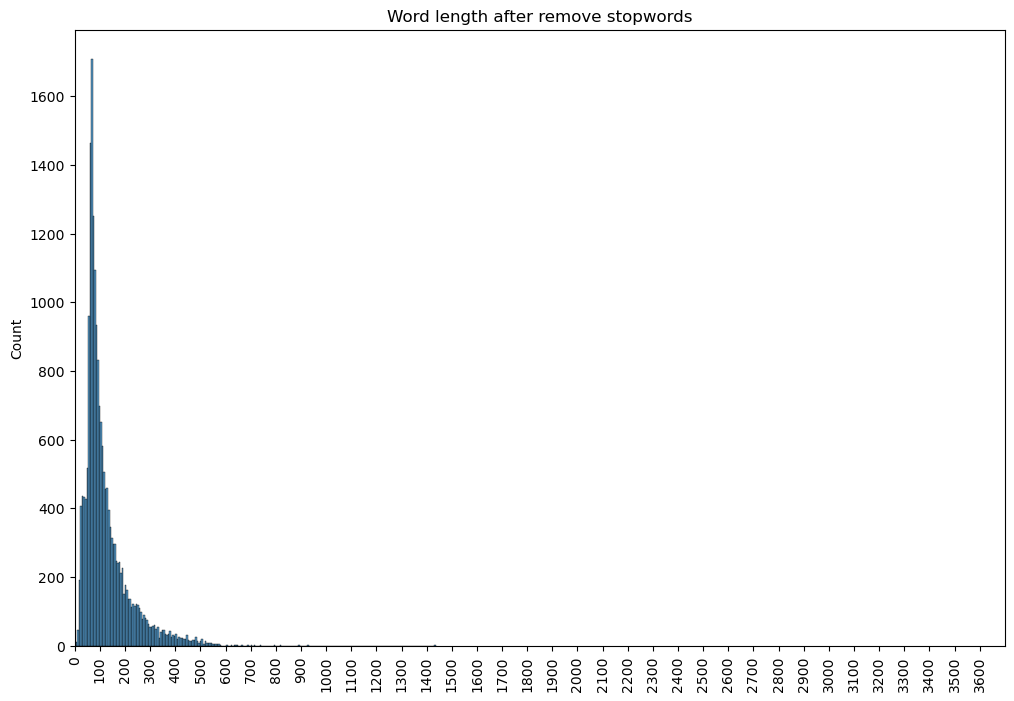

In [16]:
ws_length_count = np.array([len(train_ws) for train_ws in train_without_stops])
ws_upper_length_count = np.array([round(len(train_ws), -2) for train_ws in train_without_stops])
plt.figure(figsize = (12, 8))
sns.histplot(ws_length_count)
plt.xlim(0, 3700)
plt.xticks(np.arange(0, 3700, 100), rotation=90)
plt.title("Word length after remove stopwords")
print(f'mean: {ws_length_count.mean()}')
print(f'mean: {np.median(ws_length_count)}')

# 500 이하에 대부분이 포진
print(*sorted(Counter(ws_upper_length_count).items(), key=lambda x: -x[1])[:10])

In [17]:
def get_length_percentage(dataset, limit):
    count_under_limit = 0
    for x in dataset:
        if len(x) <= limit:
            count_under_limit += 1
    answer = (count_under_limit/len(dataset))*100
    print(f'{answer}% contains under {limit} words')

In [18]:
get_length_percentage(train_without_stops, 500)

99.385% contains under 500 words


In [19]:
sentence_words = []
for s in train_without_stops:
#     split_words = s.split()
    sentence_words.extend(s)
count_words = Counter(sentence_words)

limit = 20
used_word = len([w for w, c in count_words.items() if c > limit])
print(f'words appear more then {limit} times in total sentence: {used_word}')

words appear more then 20 times in total sentence: 11085


In [20]:
# maxlen: 4000, test f1_score: 0.8372
def padding_token(text_without_stops):
    return pad_sequences(text_without_stops, dtype=object, maxlen=500, padding='post', value='<pad>')

In [21]:
timer = Timer("padding")
train_token = padding_token(train_without_stops)
val_token = padding_token(val_without_stops)
test_token = padding_token(test_without_stops)
timer.end()
print(f'Shape: Train_{train_token.shape}, Val_{val_token.shape}, Test_{test_token.shape}')

padding process took 0.0min 0.0sec
Shape: Train_(20000, 500), Val_(5000, 500), Test_(25000, 500)


In [22]:
tokenizer = Tokenizer(num_words=10000, oov_token = 'unknown') 
# tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_token.tolist())
print(*sorted(tokenizer.word_index.items(), key=lambda x: x[1])[:10])
print(f'Total Words: {len(tokenizer.word_index.items())} but {used_word} is used')

('<pad>', 2) ('movie', 3) ('film', 4) ('one', 5) ('like', 6) ('good', 7) ('even', 8) ('time', 9) ('would', 10) ('really', 11)
Total Words: 98715 but 11085 is used


In [23]:
train_sequence = np.array(tokenizer.texts_to_sequences(train_token.tolist()), dtype=np.int32)
val_sequence = np.array(tokenizer.texts_to_sequences(val_token.tolist()), dtype=np.int32)
test_sequence = np.array(tokenizer.texts_to_sequences(test_token.tolist()), dtype=np.int32)

In [24]:
train_label = np.array(train_label, dtype=np.int32)
val_label = np.array(val_label, dtype=np.int32)
test_label = np.array(test_label, dtype=np.int32)

In [25]:
print(train_sequence.shape)
print(train_label.shape)

(20000, 500)
(20000,)


In [26]:
batch_size = 64
shuffle = False

# train_dataset = TensorDataset(torch.from_numpy(train_token), torch.from_numpy(np.array(train_label)))
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

# val_dataset = TensorDataset(torch.from_numpy(val_token), torch.from_numpy(np.array(val_label)))
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)

# test_dataset = TensorDataset(torch.from_numpy(test_token), torch.from_numpy(np.array(test_label)))
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

dataloader_path = '/kaggle/working/dataloader'
if not os.path.exists(dataloader_path):
    os.makedirs(dataloader_path)
    
with open(os.path.join(dataloader_path, 'dataloader.pkl'), 'wb') as f:
    pkl.dump({
        'data': [train_sequence, train_label, val_sequence, val_label, test_sequence, test_label],
        'tokenizer': tokenizer
             }, f, protocol=pkl.HIGHEST_PROTOCOL)